### SHAP: feature sensitivities

In [1]:
import json
import model

In [2]:
import pandas as pd
import numpy as np

In [3]:
import shap
import matplotlib.pyplot as plt

C:\Users\marke\anaconda3\envs\py38\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
C:\Users\marke\anaconda3\envs\py38\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_mask

### load test data

In [4]:
data_test_df = pd.read_parquet("./output/data_test_df.parquet")

### recreate model

In [5]:
# load training_config.json into dictionary
with open("./output/marketing_model.json") as file:
    # Load its content and make a new dictionary
    training_config = json.load(file)

In [6]:
# create model with parameters
pipe_final_new = model.ClassificationModel(training_config)

In [7]:
# load trained model
pipe_final_new.load_model("./output/marketing_model")

2023-09-11 20:21:34.419 | INFO     | model:load_model:213 - Loaded sklearn pipeline from ./output/marketing_model.


### run shap sensitivities

In [8]:
# get tranformed feature names
feature_names = pipe_final_new.get_transformed_feature_names()

In [9]:
# tranform test data
transformed_data_test = pipe_final_new.transform(data_test_df)

In [10]:
# get classifier model
xgb_classifier = pipe_final_new.model_instance["classifier"]

In [11]:
# compute SHAP values
explainer = shap.Explainer(xgb_classifier,algorithm="tree", feature_names = feature_names)
shap_values = explainer(transformed_data_test, check_additivity=True)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


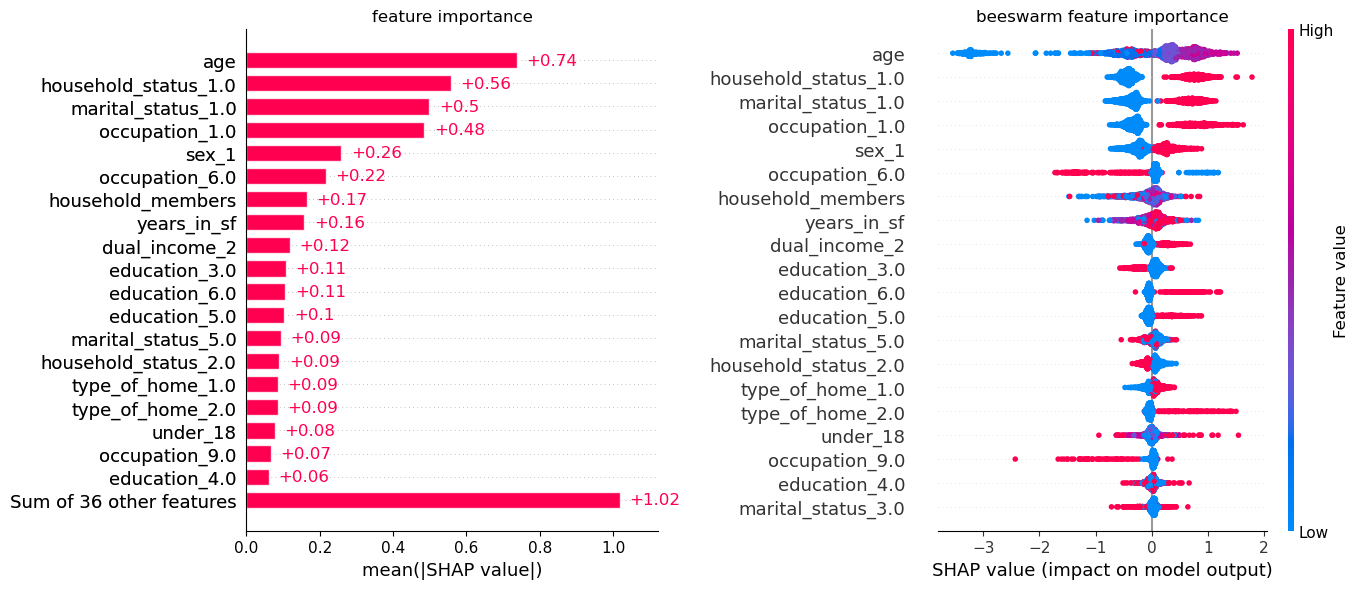

In [12]:
# Create the figure and the axes
fig = plt.figure()
ax0 = fig.add_subplot(121)
shap.plots.bar(shap_values,max_display=20,show=False)
ax0.set_title("feature importance")
ax1 = fig.add_subplot(122)
shap.summary_plot(shap_values, transformed_data_test,max_display=20, show=False)
ax1.set_title("beeswarm feature importance")
plt.gcf().set_size_inches(14,6)
plt.tight_layout() 
plt.show()

#### sensitivity analysis of Top 15 features

In [13]:
# find top features
shap_importance = pd.Series(np.abs(shap_values.values).mean(0), feature_names).abs().sort_values(ascending=False)

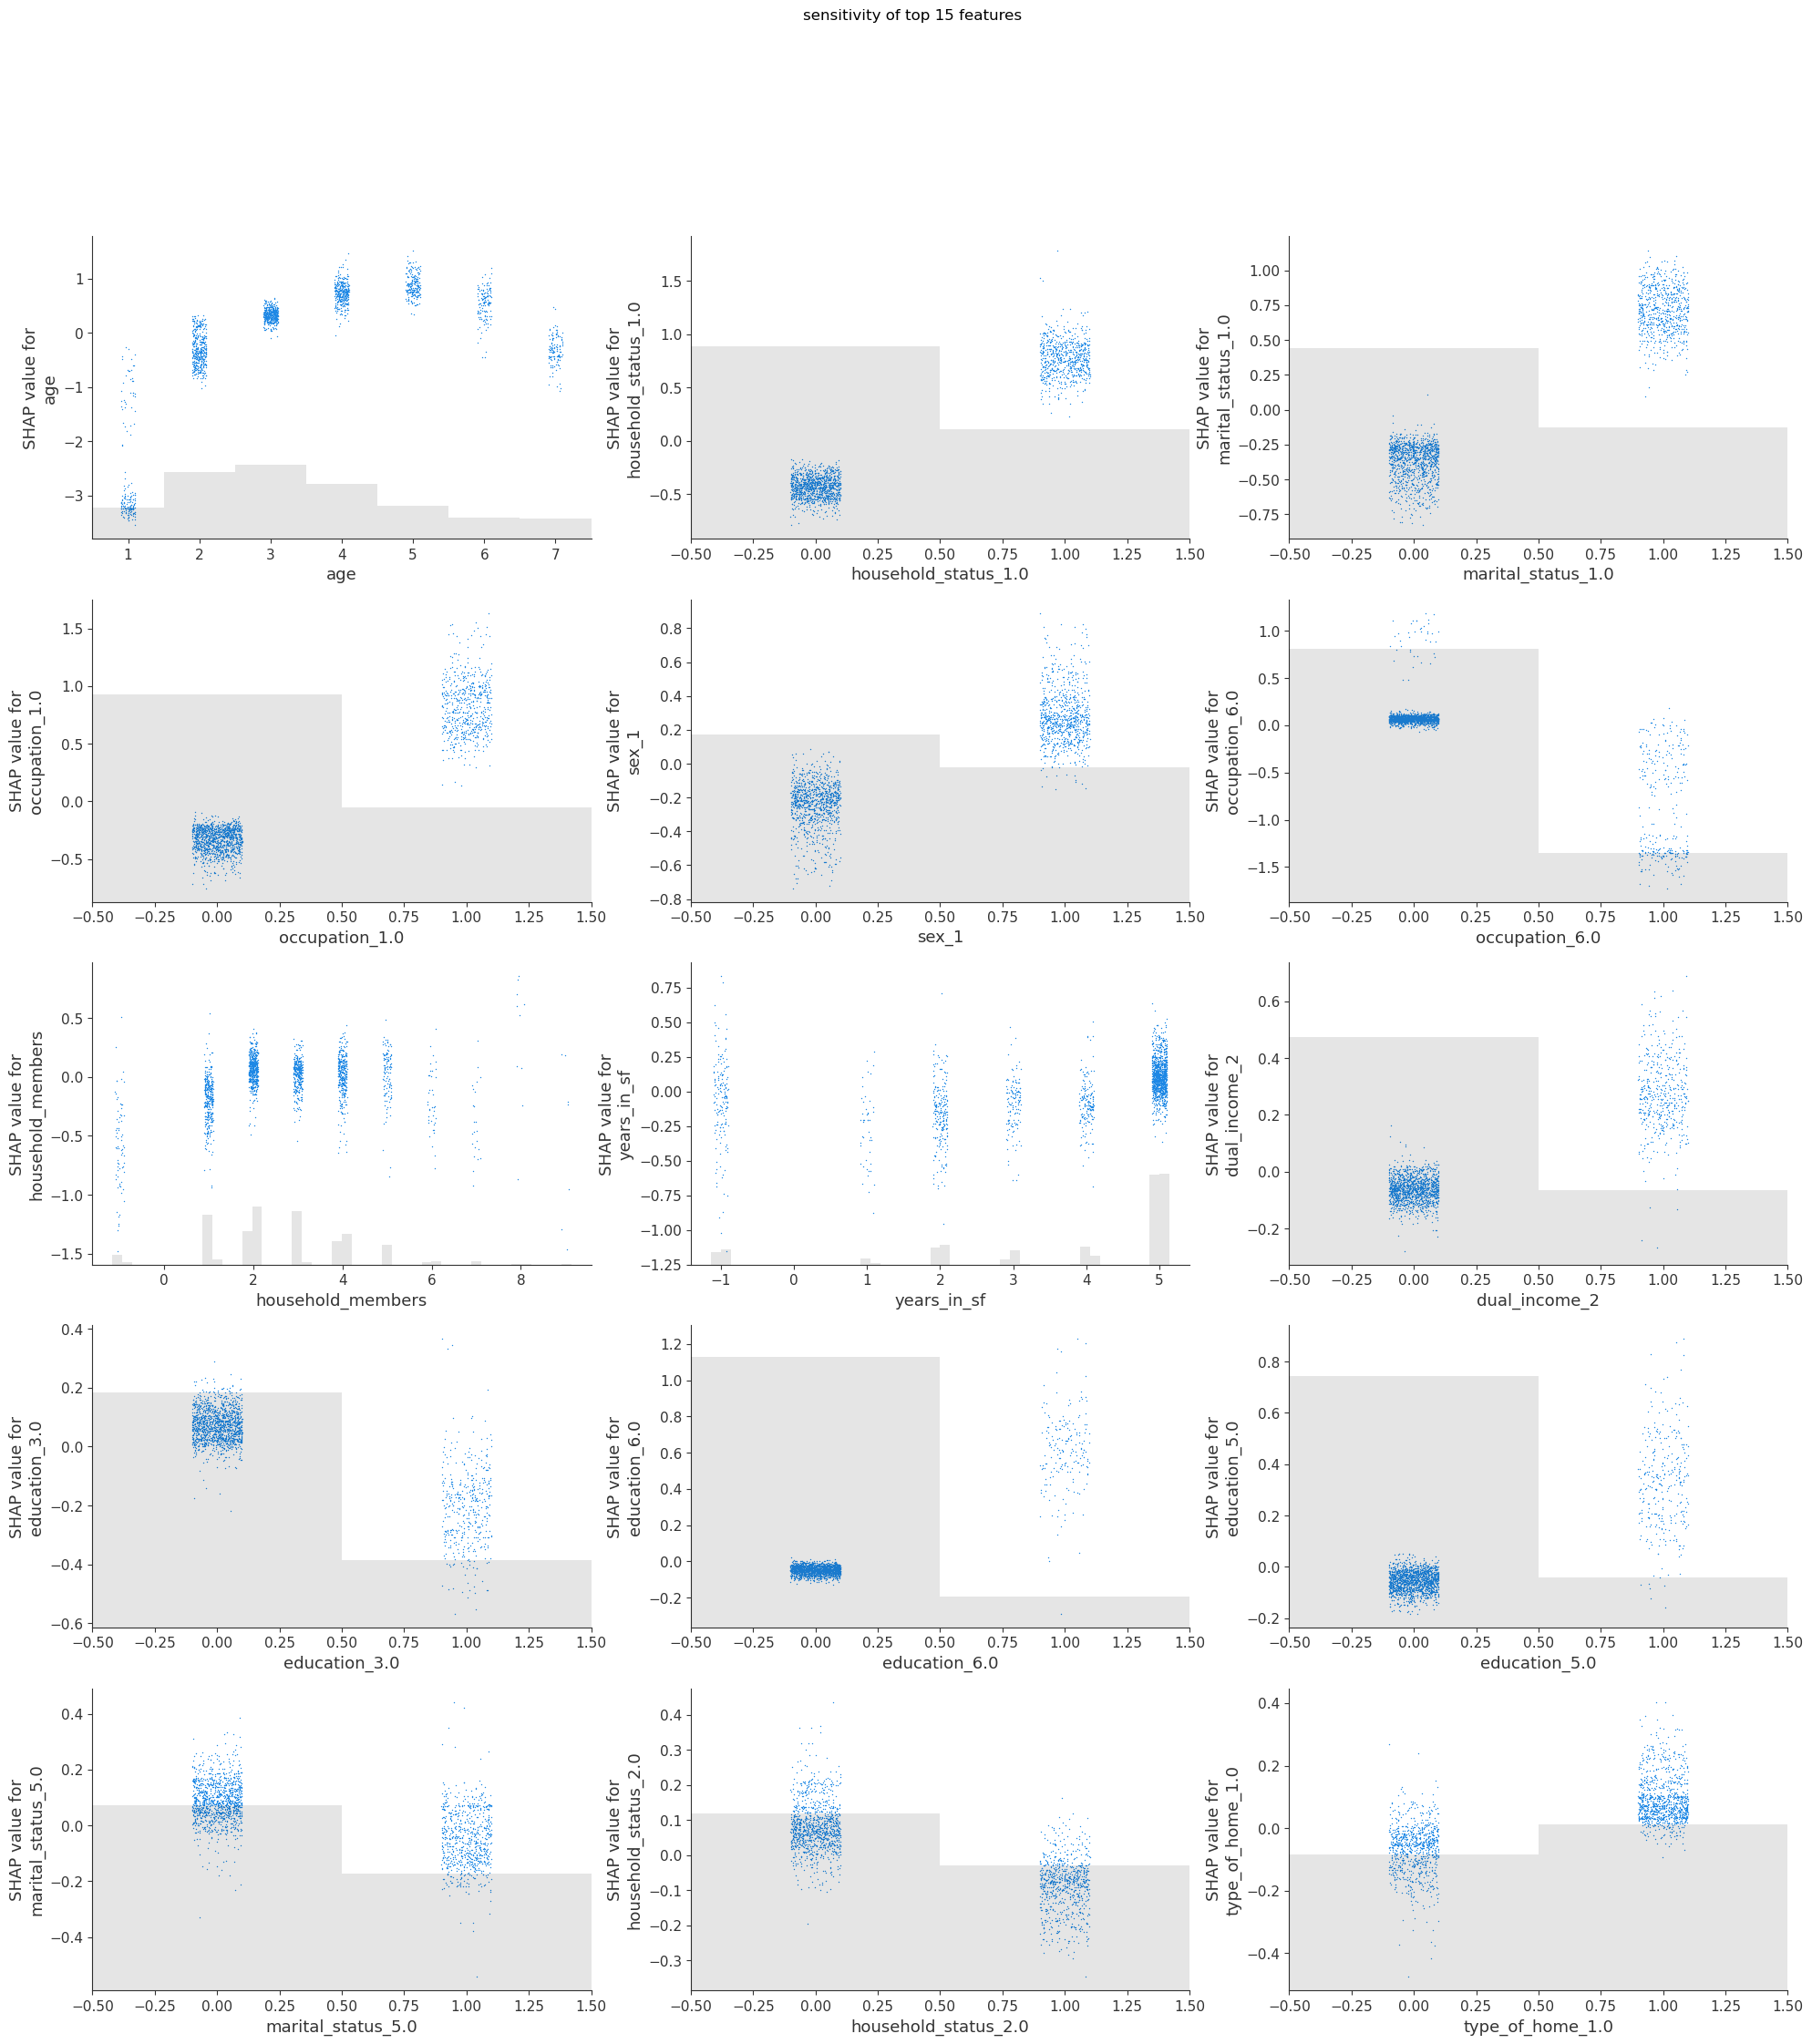

In [14]:
sensitivity_plot_cols = shap_importance[:15].index
nrows=5
ncols=3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24,25))
for index, value in enumerate(sensitivity_plot_cols,start=0):
    row = (index // ncols)
    col = index % ncols
    plt.subplot(nrows,ncols,index+1)
   # plt.title(f"{value}")
    shap.plots.scatter(shap_values[:,value],show=False, ax=axs[row,col],dot_size=1)
plt.suptitle("sensitivity of top 15 features")
plt.show()

#### local explanation (i.e. an observation)

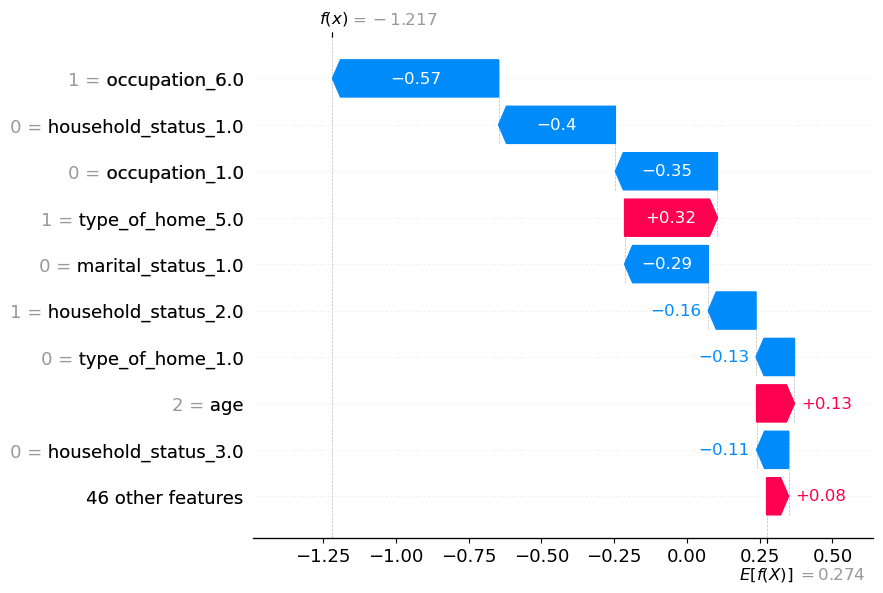

In [15]:
# observation 0. N.b. shapley values are log odds
shap.plots.waterfall(shap_values[0])

#### convert SHAP to probability

In [16]:
def shap_to_prob(shap_value):
    """ shap values are log(odds)"""
    odds = np.exp(shap_value)
    prob = round(odds / (1.0+odds),3)
    return(prob)

In [17]:
shap_to_prob(shap_values[0].base_values) # average model

0.568

In [18]:
shap_to_prob(-1.217) # model score

0.228